In [33]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display

In [12]:
# loading data
df = pd.read_csv('complaints.csv')
df.shape

<ipython-input-12-20cf7ce2ff74>:2: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


(1282355, 18)

In [13]:
df.head().T

,0,1,2,3,4
Date received,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account,Debt collection,"Credit reporting, credit repair services, or o...",Checking or savings account
Sub-product,Checking account,Other banking product or service,Payday loan debt,Credit reporting,Checking account
Issue,Managing an account,Managing an account,Communication tactics,Incorrect information on your report,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals,Frequent or repeated calls,Old information reappears or never goes away,Banking errors
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION,CURO Intermediate Holdings,Ad Astra Recovery Services Inc,ALLY FINANCIAL INC.
State,FL,WA,TX,LA,AZ
ZIP code,328XX,98204,751XX,708XX,85205


<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [14]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(383564, 2)

In [16]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

There are 18 distinct classes or categories as targets. However, it has been noticed that certain classes are encompassed by others. For example, 'Credit card' and 'Prepaid card' fall under the category 'Credit card or prepaid card.' Now, envision a new complaint related to a Credit card, and our goal is to classify it. The algorithm could correctly classify this complaint as either 'Credit card' or 'Credit card or prepaid,' but this may impact the model's overall performance. To address this issue, certain category names have been modified.

In [17]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [18]:
# Renaming categories
df2.replace({'Product': {
    'Credit reporting or other personal consumer reports': 'Credit reporting, repair or other',
    'Credit reporting, credit repair services, or other personal consumer reports':'Credit reporting, repair or other',
    'Credit reporting':'Credit reporting, repair or other',
    'Checking or savings account':'Credit reporting, repair or other',
    'Debt collection': 'Debt collection',
    'Consumer Loan': 'Consumer Loan',
    'Student loan':'Consumer Loan',
    'Payday loan, title loan, personal loan, or advance loan':'Consumer Loan',
    'Payday loan, title loan, or personal loan':'Consumer Loan',
    'Payday loan':'Consumer Loan',
    'Vehicle loan or lease':'Consumer Loan',
    'Mortgage': 'Mortgage',
    'Money transfer, virtual currency, or money service': 'Credit reporting, repair or other',
    'Prepaid card': 'Credit reporting, repair or other',
    'Credit card or prepaid card': 'Credit reporting, repair or other',
    'Debt or credit management': 'Credit reporting, repair or other',
    'Bank account or service': 'Credit reporting, repair or other',
    'Other financial service': 'Credit reporting, repair or other',
    'Money transfers': 'Credit reporting, repair or other',
    'Virtual currency': 'Credit reporting, repair or other',
    'Credit card': 'Credit reporting, repair or other',
}},
            inplace= True)

In [19]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair or other"
1,Debt collection
2,Consumer Loan
3,Mortgage


In [20]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,"Credit reporting, repair or other",I have a XXXX BIG card and made my payment whe...,0


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection
* mortgage

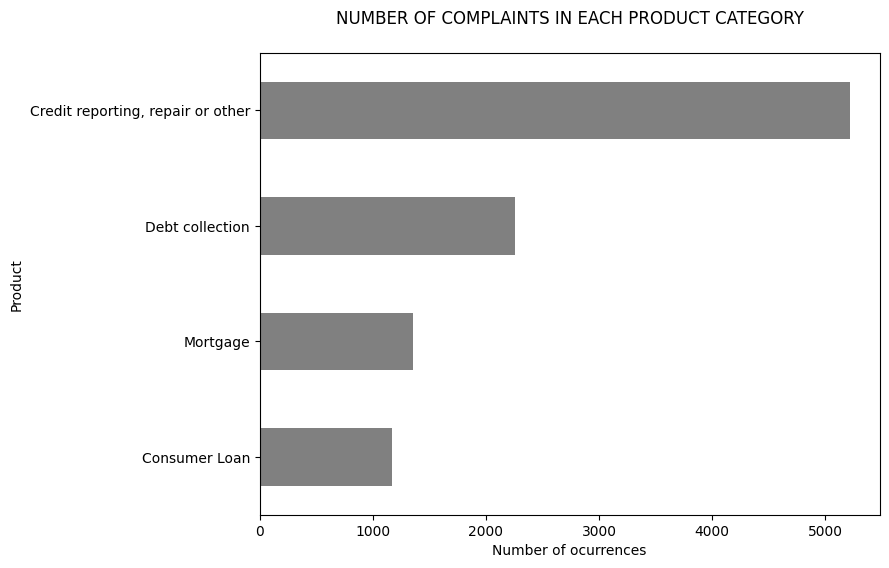

In [21]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

The text will be transformed into vectors using the Term Frequency-Inverse Document Frequency (TF-IDF) weighting method. TF-IDF assesses the significance of a word within a document by considering its frequency after preprocessing.

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# I transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

features.shape

(10000, 27507)

In [24]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Consumer Loan:
  * Most Correlated Unigrams are: student, loans, navient
  * Most Correlated Bigrams are: income based, student loan, student loans

==> Credit reporting, repair or other:
  * Most Correlated Unigrams are: card, equifax, debt
  * Most Correlated Bigrams are: loan modification, credit report, credit card

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection agency

==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: short sale, mortgage company, loan modification


<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are:
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [41]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    MultinomialNB(),
    LinearSVC(),
]

# 5 Cross-validation
CV = 5
cv_data = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_data = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [42]:
mean_accuracy = cv_data.groupby('model_name').accuracy.mean()
std_accuracy = cv_data.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8570,0.008031
MultinomialNB,0.7173,0.009278
RandomForestClassifier,0.5269,0.003110


<a id='ev'></a>
## Model Evaluation

In [43]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [44]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                   precision    recall  f1-score   support

Credit reporting, repair or other       0.85      0.93      0.89      1261
                  Debt collection       0.82      0.76      0.79       588
                    Consumer Loan       0.83      0.68      0.75       311
                         Mortgage       0.89      0.87      0.88       340

                         accuracy                           0.85      2500
                        macro avg       0.85      0.81      0.83      2500
                     weighted avg       0.85      0.85      0.85      2500



<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

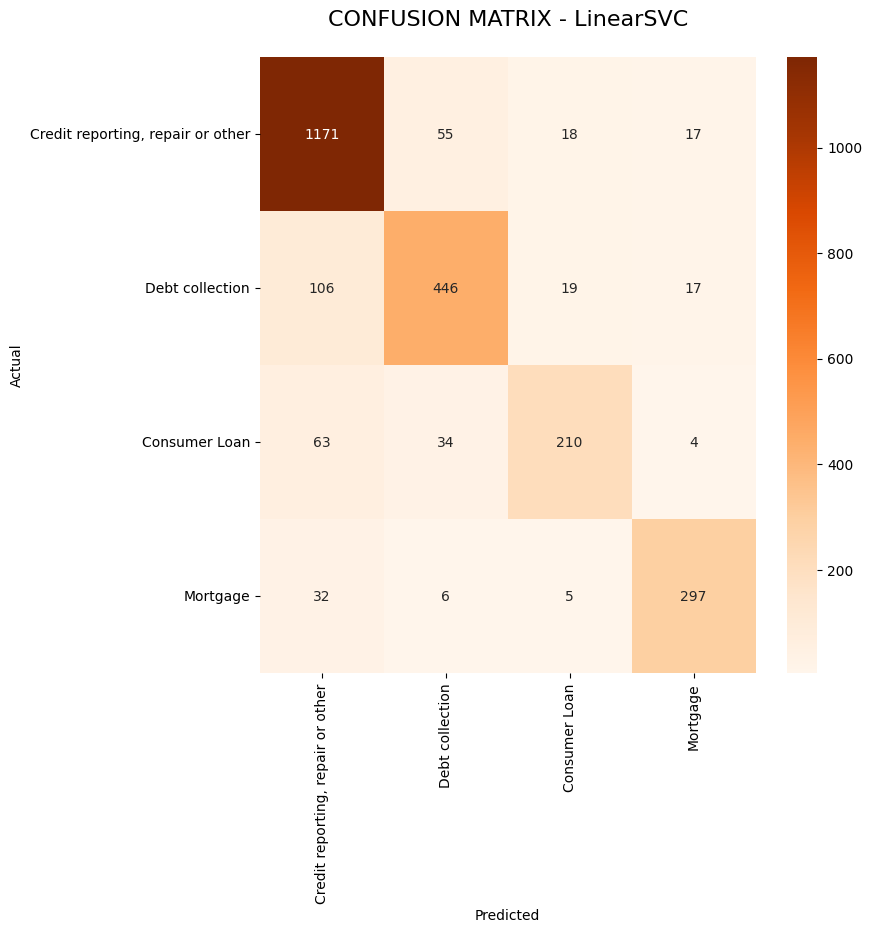

In [45]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Oranges", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

#### Most correlated terms with each category

In [48]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Consumer Loan':
  * Top unigrams: loan, navient, vehicle, loans
  * Top bigrams: chrysler capital, ad astra, 00 loan, authorize credit

==> 'Credit reporting, repair or other':
  * Top unigrams: card, equifax, experian, transunion
  * Top bigrams: collection xxxx, equifax xxxx, american express, removed report

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, owe
  * Top bigrams: credit services, trying collect, violation knowledge, account credit

==> 'Mortgage':
  * Top unigrams: mortgage, escrow, modification, home
  * Top bigrams: mortgage company, escrow account, home xxxx, mortgage xxxx


<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [58]:
new_complaint = """In XX/XX/XXXXI was informed that my father XXXX XXXX had a reverse mortgage from XXXX XXXX XXXX XXXX and then I received a letter from the above bank I since have dealt with 4 banks and 3 attorney 's and bankruptcy to finally fine a copy of my daddy 's original loan from XX/XX/XXXX. I was led to believe my father owed {>= $1,000,000} dollars when the bank only lent my father $ XXXX.XXXX XXXX was sold to XXXX XXXX XXXX and they were sold to XXXX XXXX now XXXX XXXX is the investor and XXXX is the Servicer who replaced XXXX XXXX in XXXX Tx. last summer I was in contact with XXXX   escalations department and able to establish a short sale where I could sale the house 3rd party to my daughter XXXX XXXX who is a XXXX XXXX with the XXXX XXXX XXXX XXXX district. My daughter signed all the disclosures only to find out the lender wanted gave her alone for {$390000.00} when the loan pay off was XXXX we ask XXXX  to allow us to find another lender. they agreed right before the holidays  to allow another broker. On XX/XX/XXXX. I found out the short sale letter expired and my realtor was out of the country in XXXX on an emergency plus the government shut down is not allowing me to contact hud to make them aware of all this confusion. I called XXXX XXXX and I have not received a response and my daughter who is XXXX is ready to close within 2 weeks on a house we have lived in 53 yrs. This house is our family home and I have a XXXXyr old aunt who lives with us we need help with this mortgage servicer asap. the bank wants to foreclose knowing we are closing on a loan with the government shut down there is a major conspiriacy"""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Mortgage']


In [61]:
new_complaint_2 = """Good Afternoon, I was shocked when I reviewed my credit report and found late payments reported on my credit report. I am not sure how this happened, I believe that I had made my payments to you when I received my statements. My only thought is that my monthly statement did not get to me. I still went ahead and made the payment as shown on the receipt attached, however there still discrepancies shown on my credit report the way it's reporting such as with the wrong balance, wrong date of last activities, etc. There are several and multiple inaccuracies reporting on my credit report with this account. Due to these multiple violations on the way, it's reporting, I'm asking that this account be updated and paid as agreed never late or completely removed from my credit file."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair or other']
